In [1]:
# Load libraries
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
# Download scRNA-seq data.
adata = sc.read('WMB-10Xv2-HY-raw.h5ad',
                backup_url= 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-raw.h5ad',
                var_names = 'gene_symbol')
# Subset data to 20000 cells.
sc.pp.sample(adata, n = 20000, axis = 0)
adata

  0%|          | 0.00/2.71G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 20000 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [3]:
# Check scRNA-seq observation data.
adata.obs.head()

,cell_barcode,library_label,anatomical_division_label
cell_label,,,
GAGGTGAAGGACATTA-068_A01,GAGGTGAAGGACATTA,L8TX_181126_01_C11,HY
TCATTTGAGTGGAGAA-068_E01,TCATTTGAGTGGAGAA,L8TX_181126_01_F11,HY
GGGATGACACACATGT-063_A01,GGGATGACACACATGT,L8TX_181031_01_H06,HY
GACCTGGTCGTACCGG-062_E01,GACCTGGTCGTACCGG,L8TX_181019_01_E06,HY
CCTTTCTTCCGCAAGC-063_D01,CCTTTCTTCCGCAAGC,L8TX_181031_01_C07,HY


In [4]:
# Check scRNA-seq variable data and set gene symbols as index.
adata.var_names = adata.var['gene_symbol']
adata.var_names_make_unique()
adata.var.head()

,gene_symbol
gene_symbol,
Xkr4,Xkr4
Gm1992,Gm1992
Gm19938,Gm19938
Gm37381,Gm37381
Rp1,Rp1


In [5]:
# Quality Control - mitochondrial percentage.
# There are some nice scanpy functions to perform these steps,
# but I chose this "manual" approach to highlight the underlying data structures.
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.obs['mt_count'] = adata[:, (adata.var['mt'] == True)].X.sum(axis = 1)
adata.obs['total_count'] = adata.X.sum(axis = 1)
adata.obs['mt_pct'] = (adata.obs['mt_count'] / adata.obs['total_count']) * 100
adata.obs.head()

,cell_barcode,library_label,anatomical_division_label,mt_count,total_count,mt_pct
cell_label,,,,,,
GAGGTGAAGGACATTA-068_A01,GAGGTGAAGGACATTA,L8TX_181126_01_C11,HY,826.0,18480.0,4.469697
TCATTTGAGTGGAGAA-068_E01,TCATTTGAGTGGAGAA,L8TX_181126_01_F11,HY,369.0,7990.0,4.618273
GGGATGACACACATGT-063_A01,GGGATGACACACATGT,L8TX_181031_01_H06,HY,167.0,5946.0,2.808611
GACCTGGTCGTACCGG-062_E01,GACCTGGTCGTACCGG,L8TX_181019_01_E06,HY,93.0,2822.0,3.295535
CCTTTCTTCCGCAAGC-063_D01,CCTTTCTTCCGCAAGC,L8TX_181031_01_C07,HY,116.0,4840.0,2.396694


In [6]:
# Quality control - number of cells/genes with at least 1 count.
adata.obs['n_genes_by_counts'] = np.sum(adata.X.toarray() >= 1.0, axis = 1)
adata.var['n_cells_by_counts'] = np.sum(adata.X.toarray() >= 1.0, axis = 0)
adata.obs.head()

,cell_barcode,library_label,anatomical_division_label,mt_count,total_count,mt_pct,n_genes_by_counts
cell_label,,,,,,,
GAGGTGAAGGACATTA-068_A01,GAGGTGAAGGACATTA,L8TX_181126_01_C11,HY,826.0,18480.0,4.469697,5434
TCATTTGAGTGGAGAA-068_E01,TCATTTGAGTGGAGAA,L8TX_181126_01_F11,HY,369.0,7990.0,4.618273,3617
GGGATGACACACATGT-063_A01,GGGATGACACACATGT,L8TX_181031_01_H06,HY,167.0,5946.0,2.808611,2904
GACCTGGTCGTACCGG-062_E01,GACCTGGTCGTACCGG,L8TX_181019_01_E06,HY,93.0,2822.0,3.295535,1728
CCTTTCTTCCGCAAGC-063_D01,CCTTTCTTCCGCAAGC,L8TX_181031_01_C07,HY,116.0,4840.0,2.396694,2344


In [7]:
# Filter cells with outlier number of expressed genes and mitochondrial percentage.
# This could be done with <sc.pp.filter_cells(adata, min_genes=200)> but I wanted to test a "manual" version.
adata = adata[(adata.obs.n_genes_by_counts > 200) & (adata.obs.mt_pct < 5.0), :].copy()
# Filter genes expressed in at least 3 cells.
# This could be done with <sc.pp.filter_genes(adata, min_cells=3)> but I wanted to test a "manual" version.
adata = adata[:, (adata.var.n_cells_by_counts >= 3)].copy()
adata

AnnData object with n_obs × n_vars = 16864 × 24360
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'mt_count', 'total_count', 'mt_pct', 'n_genes_by_counts'
    var: 'gene_symbol', 'mt', 'n_cells_by_counts'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [8]:
# Doublet detction.
sc.pp.scrublet(adata)

In [9]:
# Normalization.
# Make copy of counts layer before normalizing data.
adata.layers['count'] = adata.X.copy()
# Normalizing by median total counts.
sc.pp.normalize_total(adata)
# Log the data.
sc.pp.log1p(adata)

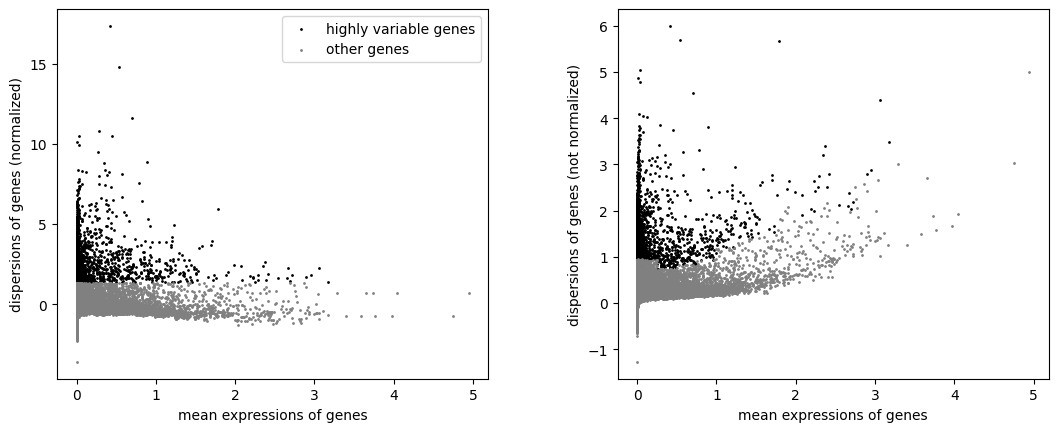

In [10]:
# Feature selection.
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata)

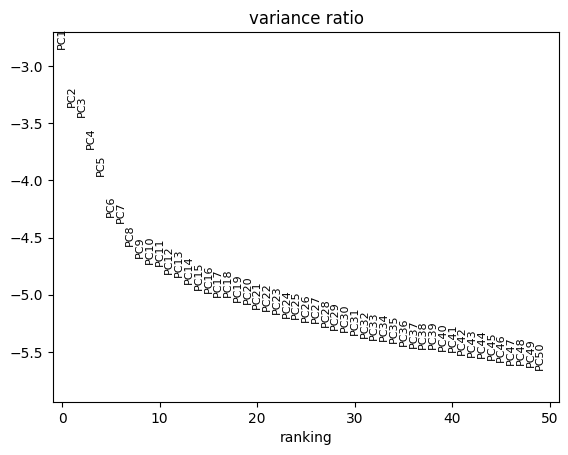

In [11]:
# Compute principal components.
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs = 50, log = True)

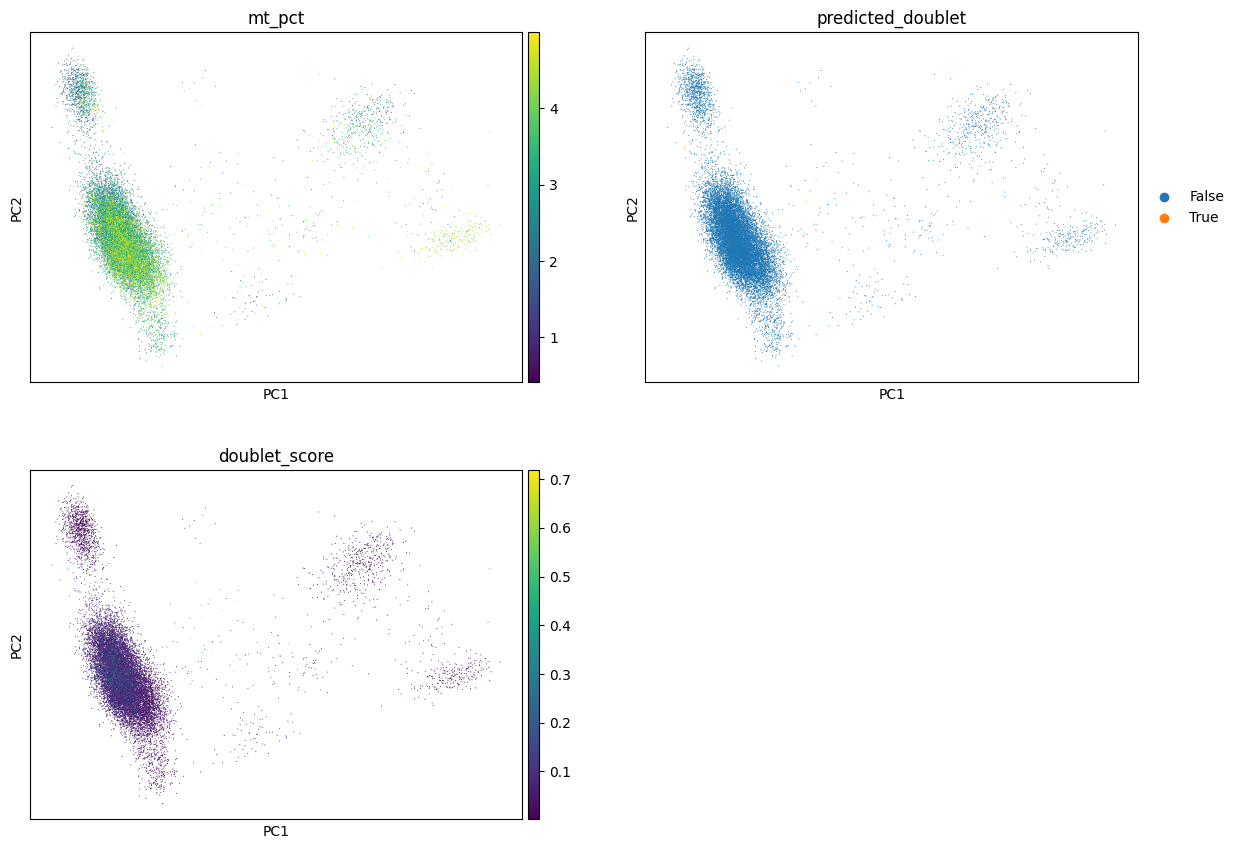

In [12]:
sc.pl.pca(
    adata,
    color=["mt_pct", "predicted_doublet", "doublet_score"],
    dimensions=[(0, 1), (0, 1), (0, 1)],
    ncols=2,
    size=2,
)

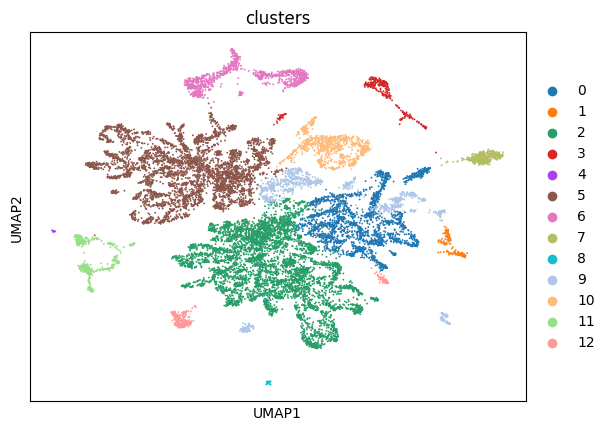

In [13]:
# Generate clusters and plot UMAP.
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor = "igraph", n_iterations = 2, key_added = "clusters", resolution = 0.1)
sc.pl.umap(adata, color = "clusters")

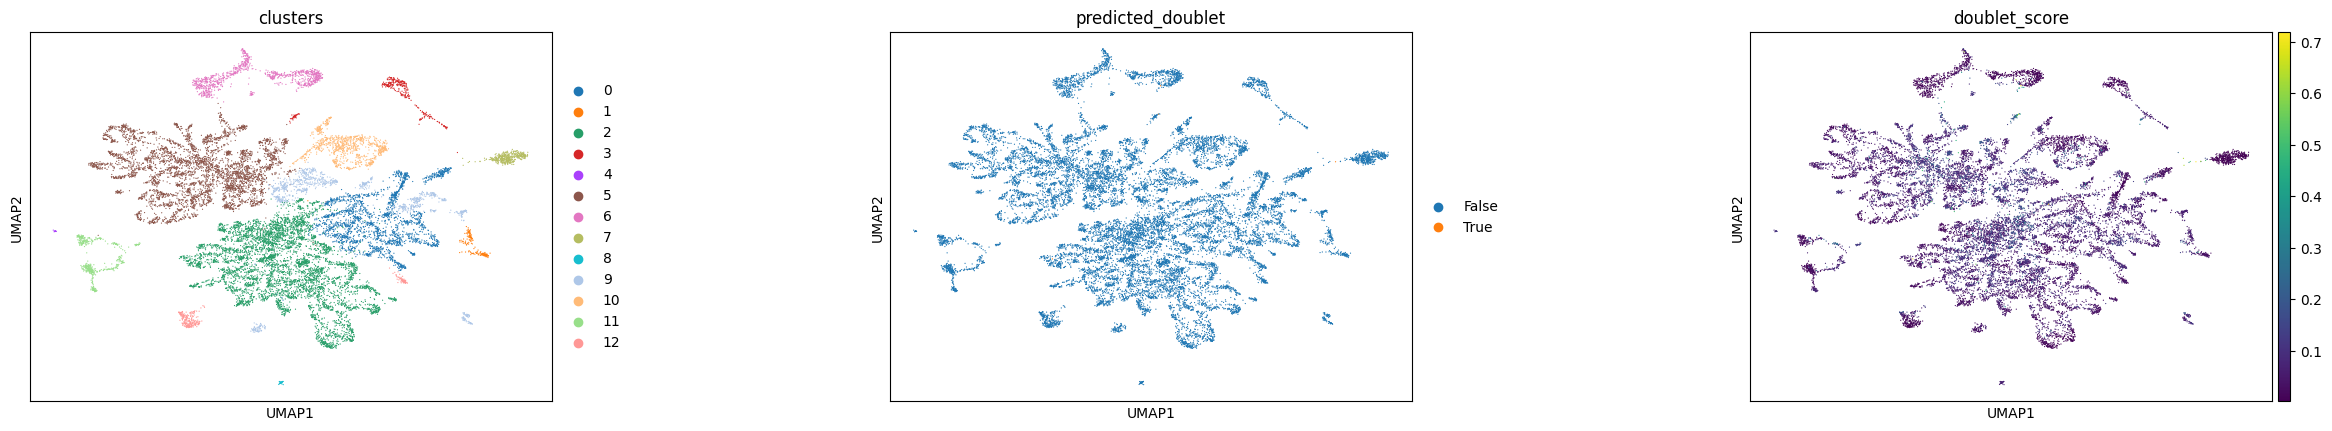

In [14]:
sc.pl.umap(adata, color = ["clusters", "predicted_doublet", "doublet_score"], wspace = 0.5, size = 3)

In [15]:
# Download cell marker information from http://bio-bigdata.hrbmu.edu.cn/CellMarker/CellMarker_download_files/file/Cell_marker_Mouse.xlsx
# Load cell marker annotation.
#annotation = pd.read_excel('Cell_marker_Mouse.xlsx')
# Download cell marker information from https://panglaodb.se/markers/PanglaoDB_markers_27_Mar_2020.tsv.gz
# Load cell marker annotation.
annotation = pd.read_csv('PanglaoDB_markers_27_Mar_2020.tsv', sep = '\t')
annotation.head()

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
4,Mm,TRY4,Acinar cells,NaN,0.007,trypsin 4,protein coding gene,1.0,Endoderm,Pancreas,NaN,NaN,NaN,NaN


In [16]:
# Check what tissues are available.
annotation.organ.value_counts()

,count
organ,
Immune system,1682
Brain,1563
GI tract,527
Kidney,444
Reproductive,411
Connective tissue,409
Vasculature,372
Pancreas,367
Liver,309


In [17]:
# Filter for brain marker genes.
annotation = annotation.loc[(annotation['organ'] == 'Brain'), :]
annotation = annotation.loc[~(annotation['official gene symbol'].isna()), :]
annotation = annotation.drop_duplicates(subset = ['official gene symbol'])
annotation = annotation.loc[(annotation['sensitivity_mouse'] >= 0.9), :]
annotation['official gene symbol'] = annotation['official gene symbol'].str.capitalize()
annotation.head()

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
196,Mm Hs,Ddc,Adrenergic neurons,AADC,0.014,dopa decarboxylase,protein-coding gene,1.0,Ectoderm,Brain,0.0,1.000000,0.004699,0.016555
197,Mm Hs,Dbh,Adrenergic neurons,DBM,0.001,dopamine beta-hydroxylase,protein-coding gene,1.0,Ectoderm,Brain,0.0,1.000000,0.000000,0.000770
327,Mm,Gh,Anterior pituitary gland cells,NaN,0.005,growth hormone,protein coding gene,1.0,Ectoderm,Brain,0.0,1.000000,0.000000,0.004371
334,Mm Hs,Prl,Anterior pituitary gland cells,NaN,0.004,prolactin,protein-coding gene,1.0,Ectoderm,Brain,0.0,1.000000,0.010652,0.001607
377,Mm Hs,Gpr37l1,Astrocytes,ETBR-LP-2,0.041,G protein-coupled receptor 37 like 1,protein-coding gene,1.0,Ectoderm,Brain,1.0,0.977049,0.002511,0.032199


In [18]:
annotation['cell type'].value_counts()

,count
cell type,
Microglia,9
Oligodendrocytes,8
Bergmann glia,7
Astrocytes,6
Pinealocytes,6
Neuroblasts,5
Immature neurons,5
Choroid plexus cells,4
Retinal ganglion cells,4


In [19]:
# Filter for marker genes present in the dataset.
merged_annotation = annotation.merge(adata.var, how = 'inner', left_on = 'official gene symbol', right_index = True)
cell_types = ['Motor neurons', 'Neurons', 'Astrocytes', 'Microglia', 'Oligodendrocytes', 'Oligodendrocyte progenitor cells']
merged_annotation = merged_annotation[merged_annotation['cell type'].isin(cell_types)]
merged_annotation.head()

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,...,sensitivity_mouse,specificity_human,specificity_mouse,gene_symbol,mt,n_cells_by_counts,highly_variable,means,dispersions,dispersions_norm
377,Mm Hs,Gpr37l1,Astrocytes,ETBR-LP-2,0.041,G protein-coupled receptor 37 like 1,protein-coding gene,1.0,Ectoderm,Brain,...,0.977049,0.002511,0.032199,Gpr37l1,False,504,True,0.092984,1.848671,3.376388
379,Mm Hs,Ntsr2,Astrocytes,NTR2,0.019,neurotensin receptor 2,protein-coding gene,1.0,Ectoderm,Brain,...,0.977049,0.000000,0.005039,Ntsr2,False,253,True,0.028624,2.179115,4.114209
390,Mm Hs,Pla2g7,Astrocytes,LDL-PLA2,0.048,phospholipase A2 group VII,protein-coding gene,1.0,Ectoderm,Brain,...,0.908197,0.011613,0.039398,Pla2g7,False,1006,False,0.064295,0.850444,1.147531
402,Mm Hs,Aldoc,Astrocytes,NaN,0.078,"aldolase, fructose-bisphosphate C",protein-coding gene,1.0,Ectoderm,Brain,...,1.000000,0.000942,0.078730,Aldoc,False,6368,True,0.440511,0.759493,1.395854
403,Mm Hs,Gja1,Astrocytes,CX43|ODOD|SDTY3|ODDD|GJAL,0.100,gap junction protein alpha 1,protein-coding gene,1.0,Ectoderm,Brain,...,0.993443,0.061519,0.089463,Gja1,False,175,True,0.040871,2.751522,5.392288


In [20]:
# Subset for highly variable genes to make list shorter for this process.
#merged_annotation = merged_annotation.loc[(merged_annotation['highly_variable'] == True), :]

# Create marker gene set.
marker_gene_set = {}

for cell_type in set(merged_annotation.loc[:, 'cell type']):
  sub_annotation = merged_annotation.loc[merged_annotation['cell type'] == cell_type, :]
  marker_gene_set[cell_type] = list(sub_annotation['official gene symbol'])

print(marker_gene_set)

{'Microglia': ['Cx3cr1', 'P2ry12', 'Gpr34', 'Fcrls', 'Fcgr3', 'Aif1', 'Ctss', 'Csf1r', 'C1qb'], 'Oligodendrocytes': ['Mog', 'Fa2h', 'Cldn11', 'Gjc3', 'Mag', 'Enpp2', 'Plp1', 'Mbp'], 'Oligodendrocyte progenitor cells': ['Olig2', 'Olig1'], 'Astrocytes': ['Gpr37l1', 'Ntsr2', 'Pla2g7', 'Aldoc', 'Gja1', 'Apoe'], 'Neurons': ['Meg3', 'Bex2']}


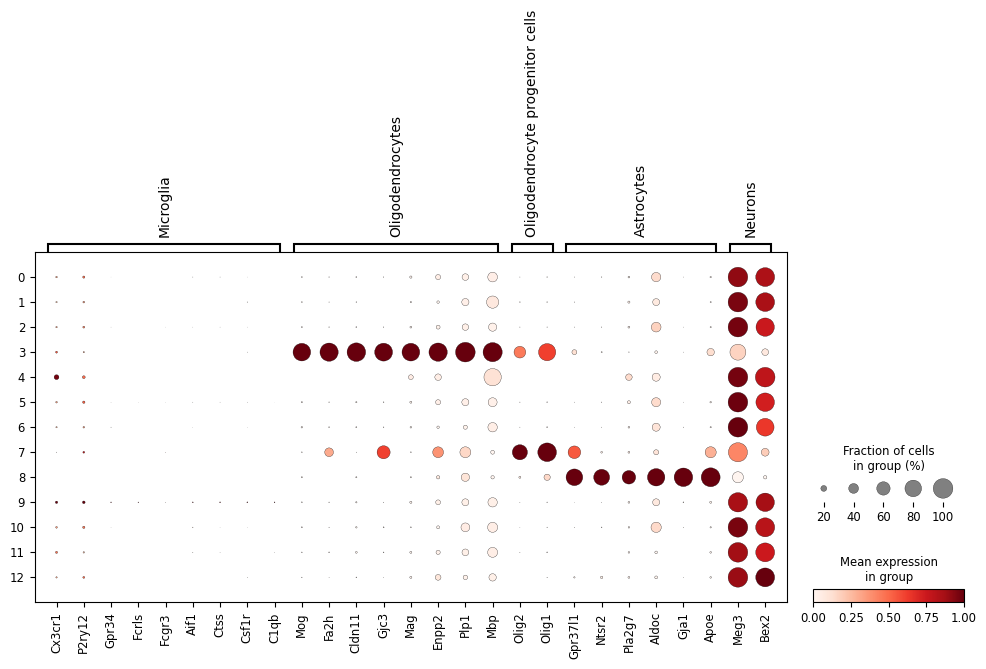

In [21]:
sc.pl.dotplot(adata, var_names = marker_gene_set, groupby = "clusters", standard_scale = "var")

In [22]:
# Differential expression analysis.
sc.tl.rank_genes_groups(adata, groupby = "clusters", method = "wilcoxon")